# Presentation: Optimizing Recipe Exposure for Tasty Bytes

## Slide 1: Introduction
Presenter: Good morning, everyone. Today, I'm excited to present the findings from our recent project aimed at optimizing recipe exposure for Tasty Bytes.

## Slide 2: Project Overview
Presenter: Let's start with a quick overview of the project and the primary goals. Our mission was to enhance the exposure of recipes during high-traffic times, ultimately driving user engagement and subscriptions for Tasty Bytes.

## Slide 3: Summary of Undertaken Work
Presenter: Now, let's dive into the work we undertook to address this challenge.
We cleaned and analyzed a dataset of 934 recipes, identifying patterns and correlations.
Explored feature importances using Logistic Regression and Random Forest Classifier models.
Introduced the key metric, the "Recipe Exposure Rate" (RER), as a crucial performance indicator.

In [3]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Load the dataset into a DataFrame
recipe_df = pd.read_csv('recipe_site_traffic_2212.csv')

recipe_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


* 5 out of 7 columns contained in the dataset have missing values
* Wrong datatype issue. The 'serving' column contains numerical values but have an object datatype
* 5 columns contain missing values and high_traffic column has the highest missing value
* There is Chicken variable and there is Chicken Breast variable but only Chicken was made mention of in the description table, 'Breast' will be dropped so that Chicken Breast and Chicken can become one variable stated in the description table

In [3]:
# Drop rows where there are fewer than 2 non-missing values
recipe_df.dropna(thresh=4, inplace=True)

# Reset the index
recipe_df.reset_index(drop=True, inplace=True)

# Check the result
print(recipe_df.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        934 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      934 non-null    object 
 6   servings      934 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 58.5+ KB
None 



In [4]:
# Print the unique values in the 'category' column before change
print("Before change:", '\n', recipe_df['category'].unique(), '\n')

# Use the str.replace() method to replace 'Chicken Breast' with 'Chicken'
recipe_df['category'] = recipe_df['category'].str.replace('Chicken Breast', 'Chicken')

# Convert the 'category' column to categorical datatype
recipe_df['category'] = pd.Categorical(recipe_df['category'])

# Check the modifications
print("After change:", '\n', recipe_df['category'].unique(), '\n')

# Confirm the change
print("Data type of 'category' column:", recipe_df['category'].dtype)

Before change: 
 ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert'] 

After change: 
 ['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable'] 

Data type of 'category' column: category


In [6]:
# Print the unique values in 'high_traffic' column before change
print("Before change:", recipe_df['high_traffic'].unique())

# Use the map() function to replace 'High' with 1 and fill NaN values with 0
recipe_df['high_traffic'] = recipe_df['high_traffic'].map({'High': 1}).fillna(0).astype('int64')

# Check the changes
print("Unique values in 'high_traffic':", recipe_df['high_traffic'].unique())

# Check the datatype
print("Data type of 'high_traffic' column:", recipe_df['high_traffic'].dtype)

Before change: ['High' nan]
Unique values in 'high_traffic': [1 0]
Data type of 'high_traffic' column: int64


### Summary of Data Cleaning and Validation

The dataset initially had 947 rows and 8 columns.

The 'category' column underwent transformation by merging the unexpected category 'Chicken Breast' into the 'Chicken' category, and its data type was converted to 'category'.

In the 'servings' column, the values '4 as a snack' and '6 as a snack' were replaced with '4' and '6' respectively, and the column was converted to an integer data type.

The 'high_traffic' column was modified by replacing 'High' with '1', filling NaN values with '0', and converting the column to an integer data type. Rows with fewer than 2 non-missing values were dropped before this operation.

After these operations, the dataset was refined, and the resulting 'high_traffic' column is now binary with values of '0' and '1'. The specific modifications led to a more consistent and usable dataset for further analysis.

## Slide 4: Key Findings
Presenter: Our exploratory analysis revealed fascinating insights:
Larger serving sizes correlated with higher recipe traffic.
The 'Chicken' category emerged as a prevalent choice.
Positive impacts from categories like 'Vegetable,' 'Potato,' and 'Pork.'
Feature importances aligned with our exploratory findings.

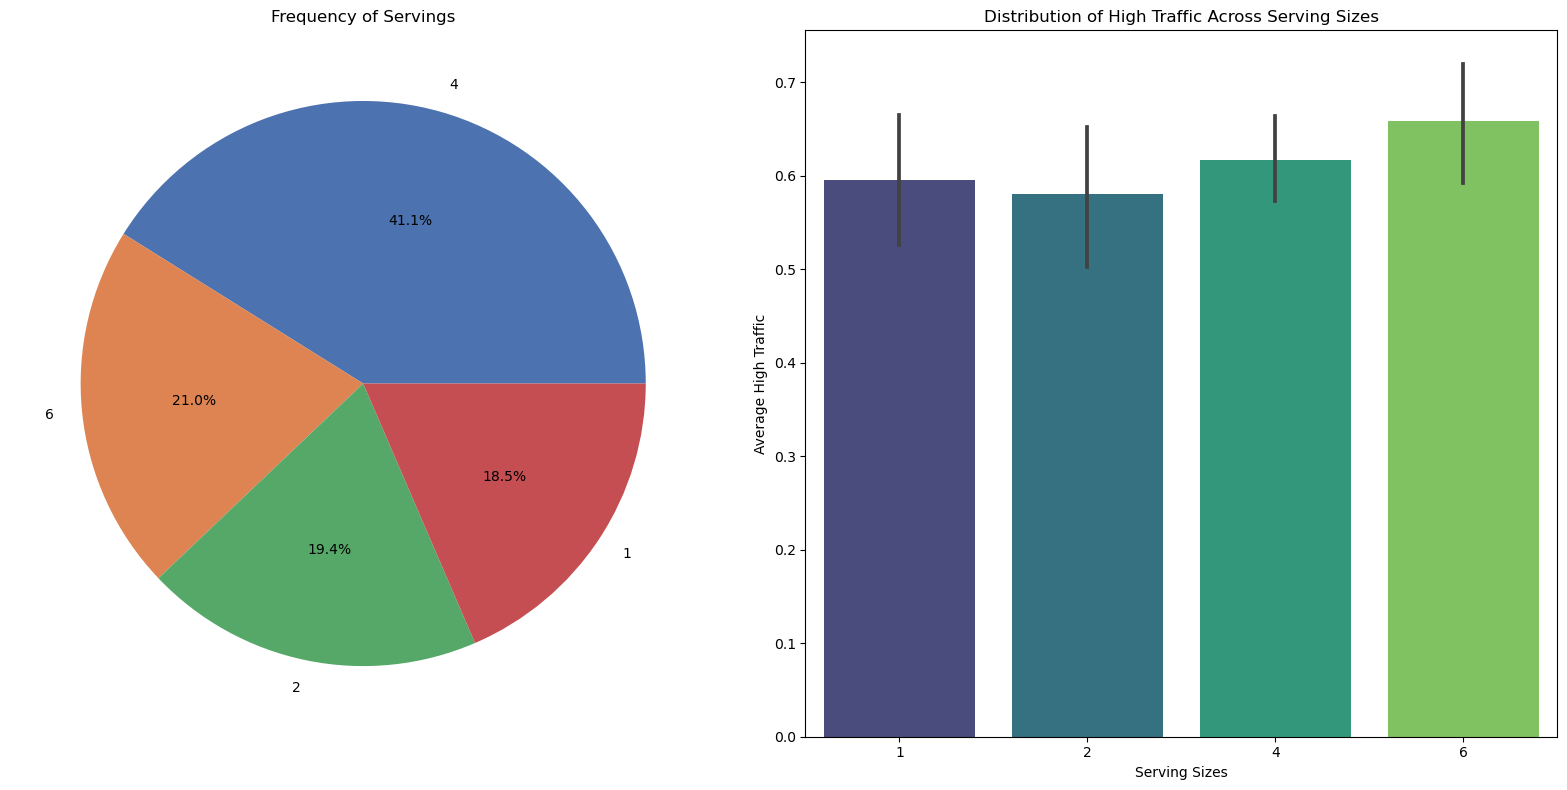

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

ser_val_counts = recipe_df['servings'].value_counts()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Create a dictionary mapping serving sizes to specific colors
color_mapping = {serving: color for serving, color in zip(ser_val_counts.index, 
                                                          sns.color_palette("deep", len(ser_val_counts)))}
pie_colors = [color_mapping[serving] for serving in ser_val_counts.index]

# Create the pie chart as the first subplot
plt.subplot(1, 2, 1)
pie_colors = [color_mapping[serving] for serving in ser_val_counts.index]
plt.pie(ser_val_counts, labels=ser_val_counts.index, colors=pie_colors, autopct='%1.1f%%')
plt.title("Frequency of Servings")

# Plot a violin plot to show the distribution of high traffic for each serving size
plt.subplot(1, 2, 2)
sns.barplot(x='servings', y='high_traffic', data=recipe_df, palette='viridis', ax=axes[1])
axes[1].set_xlabel('Serving Sizes')
axes[1].set_ylabel('Average High Traffic')
axes[1].set_title('Distribution of High Traffic Across Serving Sizes')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The pie plot indicates that 4 servings is the most common at 41.1%.
The bar plot reveals a positive trend between serving sizes and average high traffic, with recipes serving 6 having the highest traffic.
These insights could inform content strategies, such as featuring more family-sized meals. However, as the differences in traffic are relatively small, other factors may also be influential.

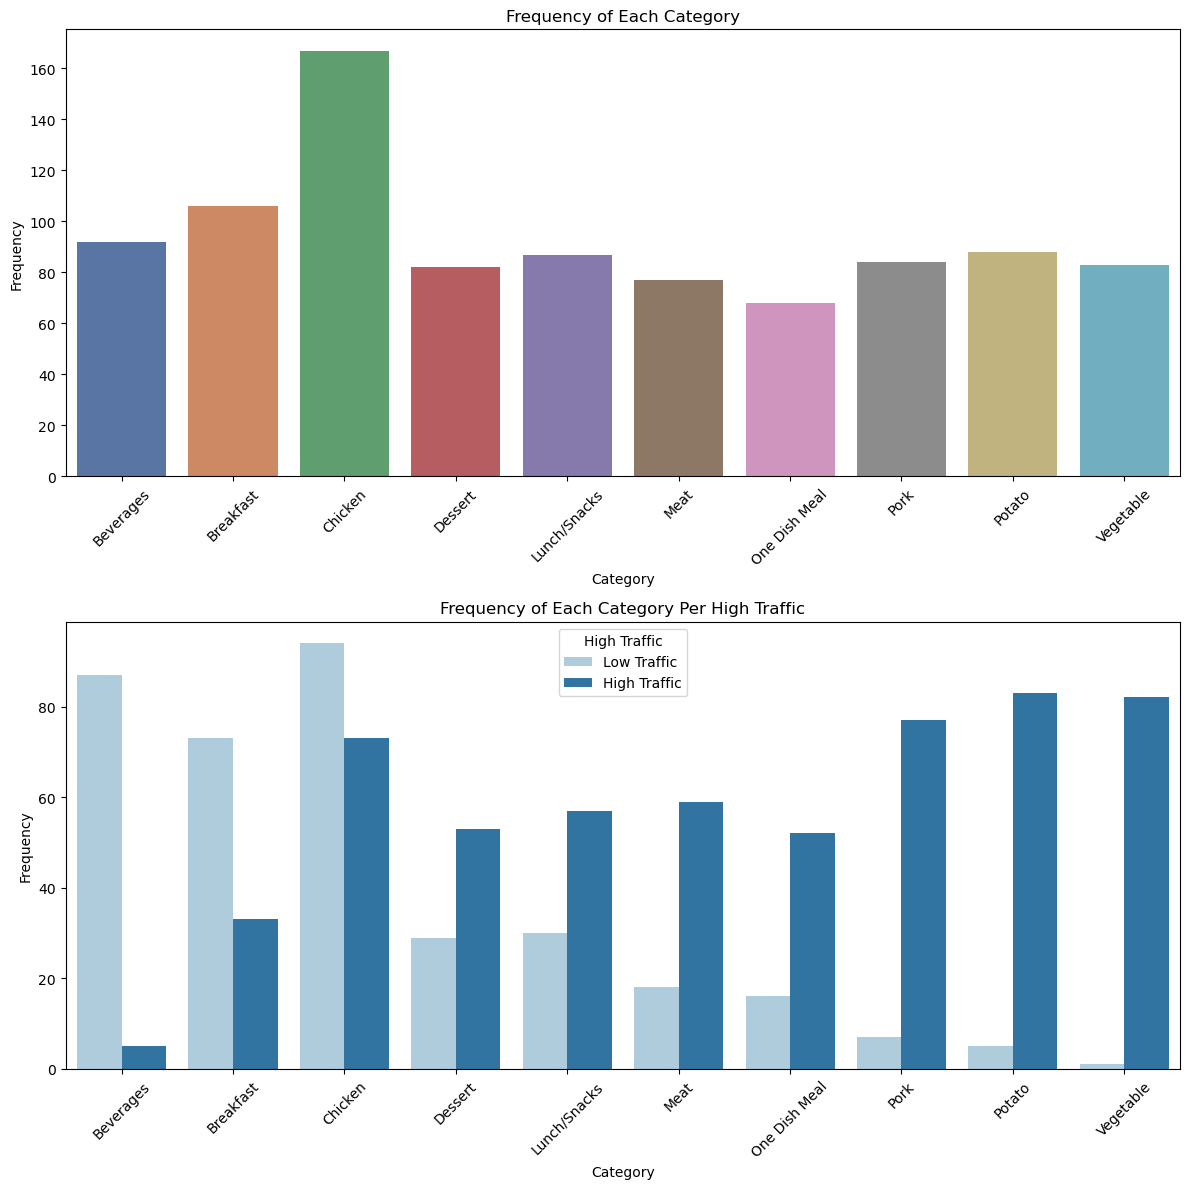

In [8]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plot the frequency of each category
sns.countplot(x='category', data=recipe_df, palette='deep', ax=axes[0])
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of Each Category')
axes[0].tick_params(axis='x', rotation=45)

# Plot a stacked bar plot to show the frequency of each category per high traffic
sns.countplot(x='category', hue='high_traffic', data=recipe_df, palette='Paired', ax=axes[1])
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Frequency of Each Category Per High Traffic')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='High Traffic', labels=['Low Traffic', 'High Traffic'])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

* The initial visualization depicts the dispersion of recipes among various categories, highlighting 'Chicken' as the most favored category.
* In the subsequent visualization, traffic levels are incorporated, unveiling that categories such as 'Vegetable', 'Potato', and 'Pork' receive substantial traffic, whereas 'Beverages' exhibit lower popularity.
* While 'Chicken' dominates in the initial plot, its traffic distribution is more evenly distributed in the second plot.

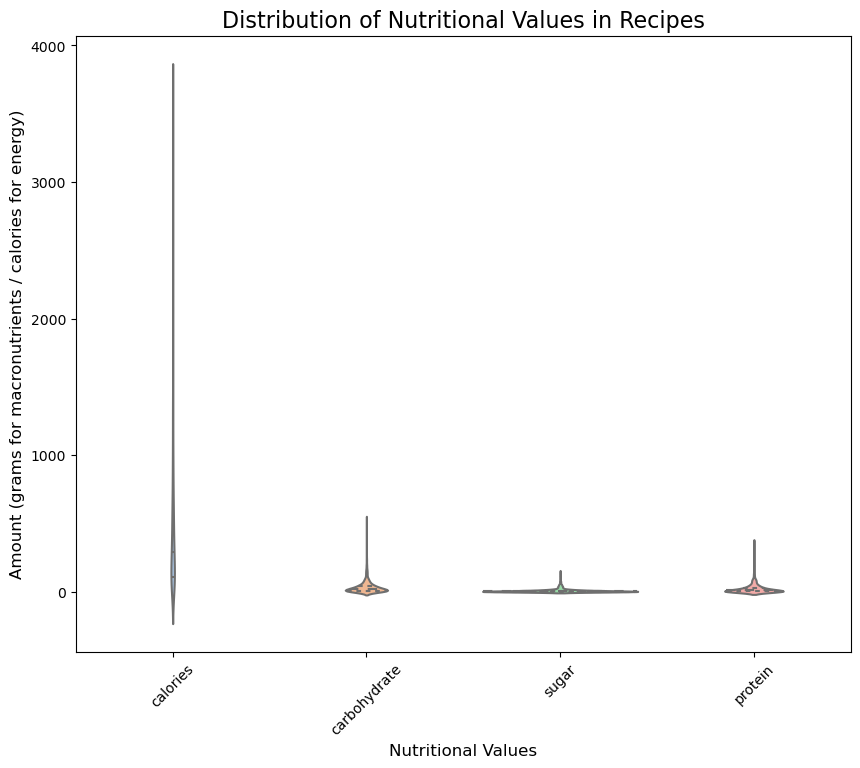

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the columns of interest
nutritional_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a plot
plt.figure(figsize=(10, 8))

# Create a violin plot
sns.violinplot(data=recipe_df[nutritional_cols], inner="quartile", palette="pastel")
plt.title('Distribution of Nutritional Values in Recipes', fontsize=16)
plt.ylabel('Amount (grams for macronutrients / calories for energy)', fontsize=12)
plt.xlabel('Nutritional Values', fontsize=12)
plt.xticks(rotation=45)

# Display the plot
plt.show()

The dataset comprising 895 recipes displays a broad spectrum of nutritional values. Both 'Calories' and 'Protein' showcase significant variability, characterized by extensive ranges and large spreads. 'Carbohydrates' exhibit a moderately wide range and spread, while sugar values, although generally lower, manifest some noteworthy high outliers. Across all four nutrients, a notable presence of outliers is observed, particularly beyond the 75th percentile.

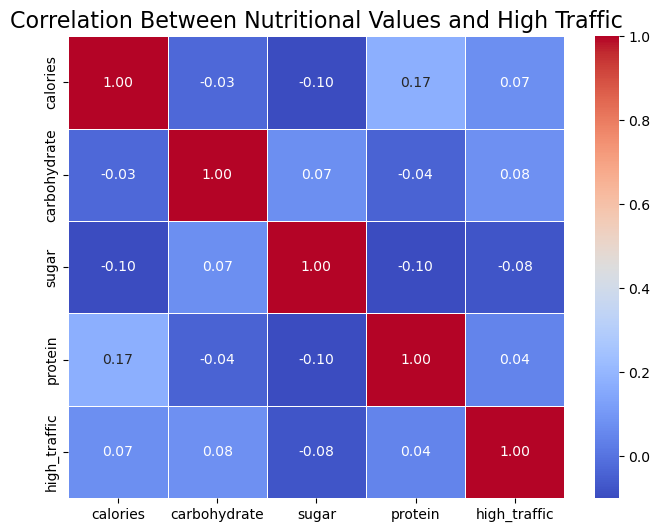

In [10]:
# Compute the correlation matrix
corr = recipe_df[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic',]].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Between Nutritional Values and High Traffic', fontsize=16)

# Display the heatmap
plt.show()

High traffic recipes have no strong linear correlation with calories, carbohydrates, sugar, or protein.

## Recap of Exploratory Analysis

### The exploration reveals the following insights:

* Recipes serving 4 are the most prevalent, yet larger serving sizes exhibit higher traffic, suggesting a preference for family-oriented meals.
* 'Chicken' stands out as a popular category, while 'Vegetables', 'Potatoes', and 'Pork' garner more traffic.
* The dataset's nutritional values display wide distributions and outliers, prompting the decision to impute missing values with medians during the modeling phase.
* Notably, there is no substantial correlation observed between nutritional values and traffic.

## Slide 5: Key Metric - Recipe Exposure Rate (RER)
Presenter: To address the problem of maximizing recipe exposure, we recommend monitoring the "Recipe Exposure Rate" (RER).
Metric Formula:

$$RER(\%) = \left(\frac{{\text{{Number of times recipe exposed during high traffic}}}}{{\text{{Total number of times recipe shown}}}}\right) \times 100$$

Initial Estimation: Our initial analysis indicates an RER of 61.46%.

# Defining Key Metrics for Business Monitoring

I propose leveraging the "Recipe Exposure Rate" (RER) as a pivotal key performance indicator. This metric offers a profound understanding of how effectively the platform amplifies the visibility of recipes during peak traffic periods. The RER can be computed using the following formula:

$$RER(\%) = \left(\frac{{\text{{Number of times recipe exposed during high traffic}}}}{{\text{{Total number of times recipe shown}}}}\right) \times 100$$

### 1- How should the business monitor what they want to achieve?

For effective monitoring of business goals, Tasty Bytes should:

**Calculate RER:** Derive the Recipe Exposure Rate regularly and establish a predefined threshold (e.g., 80%) for popular recipes. Continuously monitor this metric.

**Adjustment Threshold:** If the RER falls below the set threshold, consider making adjustments to recipe selection strategies.

**Impact Assessment:** Evaluate the impact of RER on website traffic and subscriptions. Adjustments should align with the correlation between changes in RER and corresponding shifts in website metrics.

### 2- Estimate the initial value(s) for the metric based on the current data?



In [24]:
# Calculate the RER
total_recipes = len(recipe_df)
high_traffic_recipes = recipe_df['high_traffic'].sum()
recipe_exposure_rate = (high_traffic_recipes / total_recipes) * 100

# Print the RER
print(f'Recipe Exposure Rate: {recipe_exposure_rate:.2f}%')


Recipe Exposure Rate: 61.46%


The initial estimation indicates that Tasty Bytes falls short of the targeted 80% exposure rate for popular recipes during high-traffic intervals.

## Final Summary

### 1- Summary

The dataset, initially comprising 947 rows and 8 columns, underwent thorough cleaning, resulting in a refined dataset of 934 rows. Noteworthy steps include handling missing values through median imputation, merging 'Chicken Breast' with 'Chicken' under the 'category' column, and binarizing the 'high_traffic' column.

#### Exploratory analysis unearthed key insights:

Recipes catering to larger groups tend to attract higher traffic.
'Chicken' emerged as a prevalent category.
'Vegetables,' 'Potatoes,' and 'Pork' garnered heightened traffic.
No robust correlations were identified between nutritional values and traffic.
For feature importances:

Logistic Regression emphasized positive impacts for 'Vegetable,' 'Potato,' and 'Pork,' while 'Beverages,' 'Breakfast,' and 'Chicken' showcased significant negative impact.
Random Forest Classifier underscored the importance of calories, carbohydrate, sugar, protein, and beverages.

### 2- Comparing the Two Models

Both XGBoost and Random Forest Classifier exhibited parallel performance metrics. However, XGBoost, aligning more closely with exploratory analysis insights, emerged as the preferred choice.

Key Metric:

I recommend adopting the "Recipe Exposure Rate" (RER) as the primary performance metric, with continuous monitoring and a predefined threshold (e.g., 80%).

### 3- Recommendations

Based on the comprehensive analysis, consider implementing the following strategies:

* Promote Categories with Positive Impact: Prioritize categories like 'Pork,' 'Potato,' and 'Vegetable' in recipe promotions, given their demonstrated ability to drive high traffic.

* Reevaluate Underperforming Categories: Conduct a detailed analysis of categories such as 'Beverages,' 'Breakfast,' and 'Chicken' that are currently underperforming.

* Optimize Serving Sizes: Optimize serving sizes in recipes, as there's a positive correlation between serving sizes and high traffic.

* Time-based Exposure: Tailor the timing of recipe exposure to align with the time of day, ensuring optimal visibility and engagement.

* Regular Model Testing: Periodically test models with the most recent data, ensuring predictions align with estimations and providing a data-driven approach to recipe exposure.

**Monitor and Optimize Recipe Exposure Rate (RER) as a Key Metric:**

* Compute and track RER regularly, with a predefined benchmark (e.g., 80%).
* If RER falls below the benchmark, adjust recipe selection strategies.
* Analyze RER's effect on traffic and make data-driven adjustments based on the correlation between RER changes and traffic variations.
* These recommendations, when implemented, are poised to enhance Tasty Bytes' website performance and user engagement significantly.

## Slide 7: Conclusion
Presenter: In conclusion, adopting the "Recipe Exposure Rate" (RER) as our primary metric and implementing these recommendations can significantly enhance Tasty Bytes' website performance and user engagement.

Thank you for your attention!